In [1]:
import simpy, random, logging
from queue_simulation import (
    ServiceOperation, SIMULATION_DURATION, SEED,
    SocialWorkerShifts, DutyOfficerShifts, VolunteerShifts)

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import itertools

In [2]:
sns.set();

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager

# modify matplotlib and seaborn settings
# to display Chinese 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['font.weight'] = 'medium'

sns.set(font=['sans-serif'])
sns.set_style('dark',{'font.sans-serif':['Noto Serif CJK JP']})
sns.set_context('paper', font_scale=1.5)

# 1. plot counsellor shifts

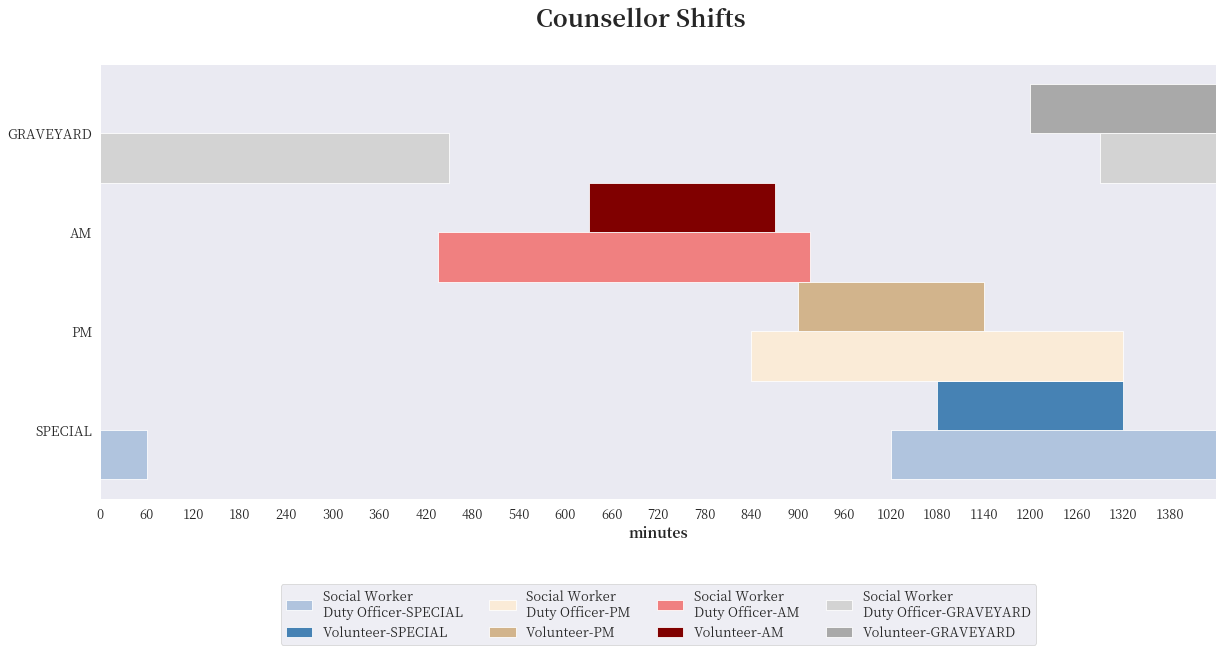

In [4]:
fig, ax = plt.subplots( figsize=(20, 8))
ax.set_xlim(0, 1440)


# special
ax.broken_barh([(SocialWorkerShifts.SPECIAL.start, 1440),
    (0, SocialWorkerShifts.SPECIAL.end%1440)],
    (1, 1), facecolors='lightsteelblue',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.SPECIAL.shift_name}')
ax.broken_barh([(VolunteerShifts.SPECIAL.start,
    VolunteerShifts.PM.duration)],
    (2, 1), facecolors='steelblue',
    label=f'Volunteer-{VolunteerShifts.SPECIAL.shift_name}')


# PM
ax.broken_barh([(SocialWorkerShifts.PM.start,
    SocialWorkerShifts.PM.duration)],
    (3, 1), facecolors='antiquewhite',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.PM.shift_name}'
)
ax.broken_barh([(VolunteerShifts.PM.start,
    VolunteerShifts.PM.duration)],
    (4, 1), facecolors='tan',
    label=f'Volunteer-{VolunteerShifts.PM.shift_name}'
)



# AM
ax.broken_barh([(SocialWorkerShifts.AM.start, 
    SocialWorkerShifts.AM.duration)],
    (5, 1), facecolors='lightcoral',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.AM.shift_name}'
)
ax.broken_barh([(VolunteerShifts.AM.start, 
    VolunteerShifts.AM.duration)],
    (6, 1), facecolors='maroon',
    label=f'Volunteer-{VolunteerShifts.AM.shift_name}'
)


# graveyard
ax.broken_barh([(SocialWorkerShifts.GRAVEYARD.start, 1440),
    (0, SocialWorkerShifts.GRAVEYARD.end%1440)],
    (7, 1), facecolors='lightgrey',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.GRAVEYARD.shift_name}'              
)
ax.broken_barh([(VolunteerShifts.GRAVEYARD.start,
    VolunteerShifts.GRAVEYARD.end)],
    (8, 1), facecolors='darkgrey',
    label=f'Volunteer-{VolunteerShifts.GRAVEYARD.shift_name}',
)


ax.set_xticks([x for x in range(0, 1440, 60)])
ax.set_xlabel('minutes')
ax.set_yticks([x for x in range(2, 9 , 2)])
ax.set_yticklabels([
    SocialWorkerShifts.GRAVEYARD.shift_name,
    SocialWorkerShifts.AM.shift_name,
    SocialWorkerShifts.PM.shift_name,
    SocialWorkerShifts.SPECIAL.shift_name,
    ][::-1])

fig.suptitle('Counsellor Shifts', fontweight='bold', fontsize=24)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=4)

plt.show()

# 2. Queue Simulation (single process)

In [5]:
queue_status = []
max_queue_length = []
num_users = []
num_users_accepted_TOS = []
num_users_rejected_TOS = []
num_users_served = []
num_users_served_g_regular = []
num_users_served_g_repeated = []
num_users_reneged = []
# num_users_reneged_g_regular = []
# num_users_reneged_g_repeated = []
num_available_counsellor_processes = []
queue_time_stats = []
renege_time_stats = []

In [6]:
# comment out line if not reproducing results
random.seed(728)
num_iterations = 1500

In [7]:
for i in tqdm(
    range(num_iterations), 
    desc='OpenUp Queue Simulation'):
    
    try:
        # create environment
        env = simpy.Environment() 

        # set up service operation and run simulation until  
        S = ServiceOperation(env=env)
        env.run(until=SIMULATION_DURATION)


        num_users.append(S.num_users)   
        num_users_accepted_TOS.append(S.num_users_TOS_accepted)
        num_users_rejected_TOS.append(S.num_users_TOS_rejected)
        max_queue_length.append(S.user_queue_max_length)
        queue_status.extend(S.queue_status)
        num_available_counsellor_processes.extend(S.num_available_counsellor_processes)
        num_users_served.append(S.served)
        num_users_served_g_regular.append(S.served_g_regular)
        num_users_served_g_repeated.append(S.served_g_repeated)
        num_users_reneged.append(S.reneged)
        queue_time_stats.append(S.queue_time_stats)
        renege_time_stats.append(S.renege_time_stats)
    #     num_users_reneged_g_regular.append(S.reneged_g_regular)
    #     num_users_reneged_g_repeated.append(S.reneged_g_repeated)
    except ValueError:
        print(f'Negative delay at {i}.  Results are dropped.')

OpenUp Queue Simulation: 100%|██████████| 1200/1200 [16:05<00:00,  1.24it/s]


In [8]:
num_users = pd.Series(num_users, name='number of users')
num_users_accepted_TOS = pd.Series(num_users_accepted_TOS, name='number of users accepted TOS')
num_users_rejected_TOS = pd.Series(num_users_rejected_TOS, name='number of users rejected TOS')
num_users_served = pd.Series(num_users_served, name='number of users served')
num_users_served_g_regular = pd.Series(num_users_served_g_regular, name='number of users served')
num_users_served_g_repeated = pd.Series(num_users_served_g_repeated, name='number of repeated users served')
num_users_reneged = pd.Series(num_users_reneged, name='number of users reneged')
# num_users_reneged_g_regular = pd.Series(num_users_reneged_g_regular, name='number of users reneged')
# num_users_reneged_g_repeated = pd.Series(num_users_reneged_g_repeated, name='number of repeated users reneged')
# queue_status = pd.Series(queue_status, name='number of instances queue exceeded four users')
queue_status = np.array(queue_status)
max_queue_length = pd.Series(max_queue_length, name='max queue length')

In [9]:
# function to calculate classification confidence intervals
# parameter: stats - list of confidence intervals, which must be ordered
#            metadata - any string to annotate printout, can be None
# precondition - metadata must be a string or None, and stats must be a list
#                  The check is commented out for now as asserts should 
#               be done outside function
# returns: cutoff values at 2.5% and 95% percentiles
def calculate_confidence_intervals(stats, metadata=None):
    # if not isinstance(metadata, None) or \
    #     not isinstance(metadata, str) or \
    #     not isinstance(stats, list):
    #     return
        
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(stats, q_lower)
    upper_percentile = np.percentile(stats, q_upper)
    mean = np.mean(stats)
        
    print('\n%s %d%% Confidence interval:' % (
        metadata, confidence_interval) )
    print('----------------------------')
    print('%.1f%% percentile: %.5f' % (q_lower, lower_percentile) )
    print('%.1f%% percentile: %.5f\n' % (q_upper, upper_percentile) )
    print('mean value: %.5f' % mean)
    return (lower_percentile, upper_percentile, mean)

In [10]:
def plot_distribution(series, filename):
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(series, q_lower)
    upper_percentile = np.percentile(series, q_upper)
    mean = np.mean(series)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5) )
    sns.distplot(series, ax=ax)
    ax.axvline(x=lower_percentile, linestyle='--' )
    ax.axvline(x=upper_percentile, linestyle='--' )
    ax.axvline(x=mean, linestyle=':', linewidth=2 )
    
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


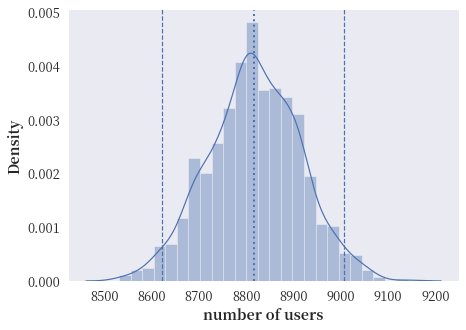

In [11]:
plot_distribution(num_users, 'num_users')

In [12]:
lower, upper, mean = calculate_confidence_intervals(
    num_users.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 8621.97500
97.5% percentile: 9007.02500

mean value: 8817.01417


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


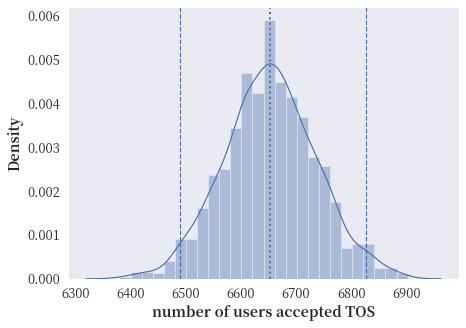

In [13]:
plot_distribution(num_users_accepted_TOS, 'num_users_accepting_TOS')

In [14]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_accepted_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 6489.97500
97.5% percentile: 6827.00000

mean value: 6652.85000


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


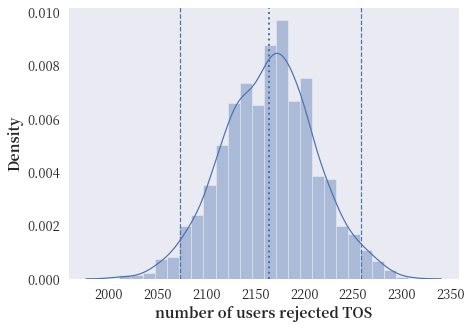

In [15]:
plot_distribution(num_users_rejected_TOS, 'num_users_rejecting_TOS')

In [16]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_rejected_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2072.95000
97.5% percentile: 2258.02500

mean value: 2164.16417


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


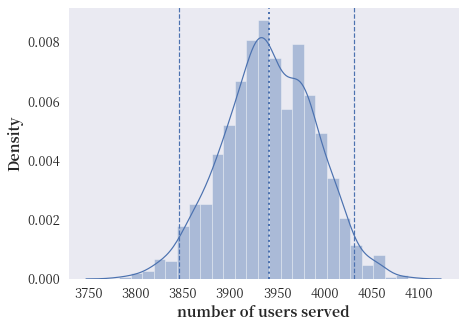

In [17]:
plot_distribution(num_users_served, 'num_users_served')

In [18]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 3845.97500
97.5% percentile: 4031.00000

mean value: 3941.25917


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


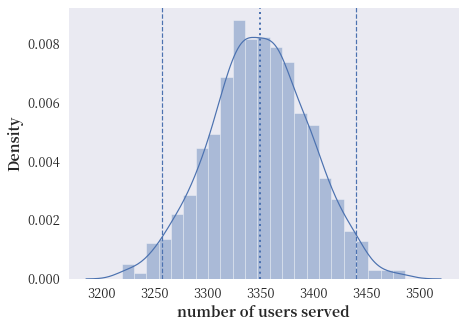

In [19]:
plot_distribution(num_users_served_g_regular, 'num_users_served_g_regular')

In [20]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_regular.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 3257.00000
97.5% percentile: 3440.02500

mean value: 3349.26750


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


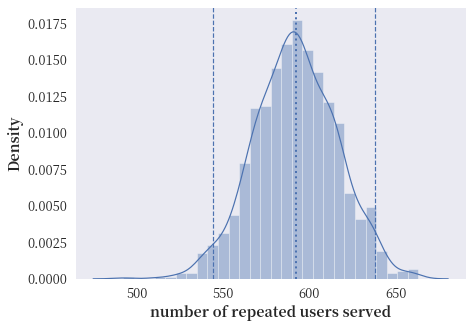

In [21]:
plot_distribution(num_users_served_g_repeated, 'num_users_served_g_repeated')

In [22]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_repeated.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 544.00000
97.5% percentile: 638.00000

mean value: 591.99167


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


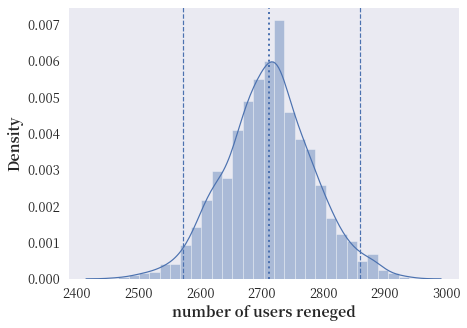

In [23]:
plot_distribution(num_users_reneged, 'num_users_reneged')

In [24]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_reneged.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2572.97500
97.5% percentile: 2859.05000

mean value: 2711.58667


In [25]:
# plot_distribution(num_users_reneged_g_regular, 'num_users_reneged_g_regular')

In [26]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_regular.sort_values().to_list() )

In [27]:
# plot_distribution(num_users_reneged_g_repeated, 'num_users_reneged_g_repeated')

In [28]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_repeated.sort_values().to_list() )

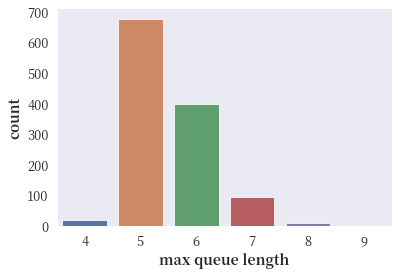

In [29]:
max_queue_length_count = sns.countplot(x='max queue length', data=max_queue_length.to_frame())

max_queue_length_count.get_figure().savefig(f'max_queue_length_count.png', dpi=300, bbox_inches='tight')

In [30]:
queue_status = pd.DataFrame(queue_status.tolist(), columns=['weekday', 'hour', 'queue_length'])

In [31]:
queue_status['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [32]:
queue_status

,weekday,hour,queue_length
0,Sunday,0,0
1,Sunday,0,0
2,Sunday,0,0
3,Sunday,1,0
4,Sunday,1,1
...,...,...,...
8389911,Monday,23,0
8389912,Monday,23,0
8389913,Monday,23,0
8389914,Monday,23,0


In [33]:
queue_status['total']=1

In [34]:
totals = queue_status.groupby(
    ['weekday', 'hour', 'queue_length']).sum()

In [35]:
totals = totals.reset_index()

In [36]:
totals

,weekday,hour,queue_length,total
0,Friday,0,0,28072
1,Friday,0,1,7797
2,Friday,0,2,3431
3,Friday,0,3,1773
4,Friday,0,4,885
...,...,...,...,...
895,Wednesday,22,5,51
896,Wednesday,22,6,14
897,Wednesday,23,0,16443
898,Wednesday,23,1,113


In [37]:
totals = pd.pivot_table(totals, values='total', columns=['queue_length'],
              index=['weekday', 'hour'], aggfunc=np.sum, fill_value=0)

In [38]:
totals_percent = totals.div(totals.sum(axis=1), axis=0)#.round(2)

In [39]:
totals_percent

queue_length           0         1         2         3         4         5  \
weekday   hour                                                               
Friday    0     0.663656  0.184331  0.081113  0.041916  0.020922  0.007376   
          1     0.886213  0.102534  0.010859  0.000393  0.000000  0.000000   
          2     0.840736  0.140345  0.017373  0.001486  0.000061  0.000000   
          3     0.794233  0.176361  0.026906  0.002376  0.000099  0.000025   
          4     0.816964  0.158502  0.022655  0.001824  0.000054  0.000000   
...                  ...       ...       ...       ...       ...       ...   
Wednesday 19    0.936318  0.048534  0.013820  0.001328  0.000000  0.000000   
          20    0.999561  0.000439  0.000000  0.000000  0.000000  0.000000   
          21    0.999831  0.000169  0.000000  0.000000  0.000000  0.000000   
          22    0.856044  0.081688  0.040146  0.015084  0.005107  0.001514   
          23    0.992875  0.006823  0.000302  0.000000  0.000000  0.000000   

queue_length           6         7    8    9  
weekday   hour                                
Friday    0     0.000567  0.000118  0.0  0.0  
          1     0.000000  0.000000  0.0  0.0  
          2     0.000000  0.000000  0.0  0.0  
          3     0.000000  0.000000  0.0  0.0  
          4     0.000000  0.000000  0.0  0.0  
...                  ...       ...  ...  ...  
Wednesday 19    0.000000  0.000000  0.0  0.0  
          20    0.000000  0.000000  0.0  0.0  
          21    0.000000  0.000000  0.0  0.0  
          22    0.000416  0.000000  0.0  0.0  
          23    0.000000  0.000000  0.0  0.0  

[168 rows x 10 columns]

In [40]:
totals_percent2 = totals_percent.reset_index()

In [41]:
totals_percent2['day_int'] = totals_percent2['weekday'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [42]:
totals_percent2 = totals_percent2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['weekday', 'hour']).drop(columns=['day_int'])

In [43]:
totals_percent2['>=2'] = totals_percent2[totals_percent2.columns[totals_percent2.columns >= 2]].sum(axis=1)

In [44]:
totals_percent2.reset_index(inplace=True)

In [45]:
totals_percent3 = totals_percent2[['weekday', 'hour', 0, 1, '>=2']].copy()

In [46]:
totals_percent3[totals_percent3['weekday']=='Sunday']

queue_length,weekday,hour,0,1,>=2
0,Sunday,0,0.671066,0.154731,0.174204
1,Sunday,1,0.863104,0.121894,0.015002
2,Sunday,2,0.820108,0.156596,0.023296
3,Sunday,3,0.807552,0.163776,0.028672
4,Sunday,4,0.810198,0.165037,0.024765
5,Sunday,5,0.796360,0.173786,0.029855
6,Sunday,6,0.736228,0.215618,0.048154
7,Sunday,7,0.779563,0.171914,0.048524
8,Sunday,8,0.804542,0.162154,0.033304
9,Sunday,9,0.791549,0.170164,0.038287


In [47]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR, 
    MAX_SIMULTANEOUS_CHATS,
    NUM_DUTY_OFFICERS,
    NUM_SOCIAL_WORKERS,
    NUM_VOLUNTEERS
)

In [48]:
NUM_DUTY_OFFICERS

{'GRAVEYARD': 1, 'AM': 1, 'PM': 1, 'SPECIAL': 0}

In [49]:
MAX_SIMULTANEOUS_CHATS

{'SOCIAL_WORKER': 3, 'DUTY_OFFICER': 1, 'VOLUNTEER': 2}

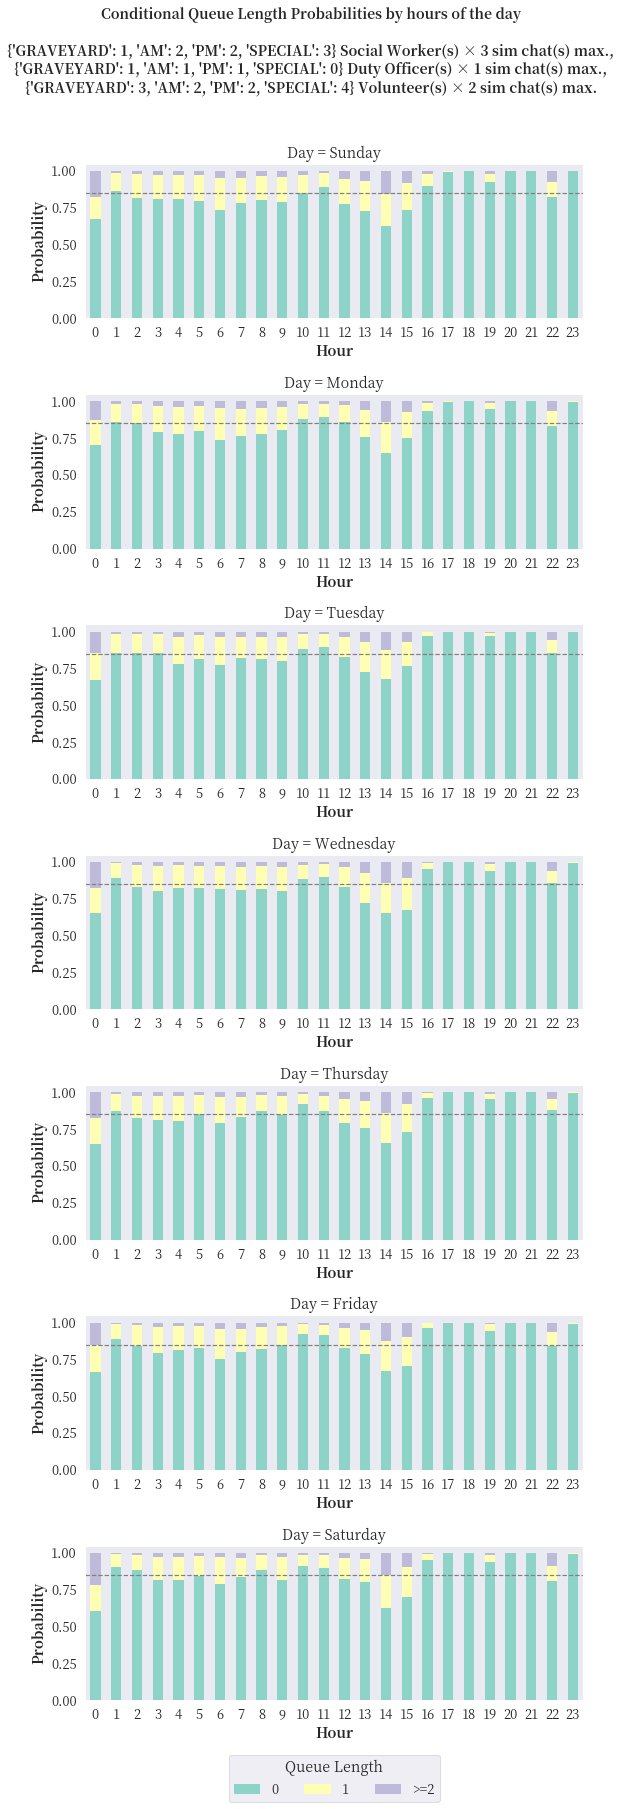

In [50]:
fig, ax = plt.subplots(7, 1, figsize=(8,25) )
palette = sns.color_palette("Set3")

fig.suptitle(f'Conditional Queue Length Probabilities by hours of the day\n\n'
    f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
    f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
    f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
    fontsize=14, weight='heavy',
    fontweight=1000, y=1.01)

for i, day in enumerate(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
    'Friday', 'Saturday']):
    
    dataframe = totals_percent3[totals_percent3['weekday']==day].copy()
    dataframe.set_index('hour').plot.bar(
        stacked=True,
        ax=ax[i],
        linewidth=.01,
        color=palette
    )

    ax[i].axhline(y=.85, linestyle='--', color='grey')
#     ax[i].set_xticklabels(labels=[f'{x[:3]}-{x[-1]} hr' 
#         if x[-2:] == '_0' else ''
#         for x in dataframe.index])

    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Probability')
    ax[i].set_title(f'Day = {day}')
    ax[i].set_xticklabels(dataframe['hour'], rotation=0)
    
    
    
    if day == 'Saturday':
        ax[i].legend(loc='lower center', 
                     bbox_to_anchor=(0.5, -.7), 
                     ncol=3,
                     title='Queue Length'
                    
                    )
    else:
        ax[i].get_legend().remove()

    
fig.tight_layout()

fig.savefig(f'queue_length_prob_plot.png', dpi=300, bbox_inches='tight')

In [51]:
# queue_plot = sns.catplot(col='weekday', y='hour', col_wrap=4,
#     col_order=['Sunday',
#         'Monday',
#         'Tuesday',
#         'Wednesday',
#         'Thursday',
#         'Friday',
#         'Saturday'],
#     data=queue_status, kind="count",
#     height=4, aspect=1);
# queue_plot.savefig(f'queue_blowup.png', dpi=300, bbox_inches='tight')

In [52]:
queue_time_stats = pd.DataFrame(
    itertools.chain.from_iterable(queue_time_stats), columns=['weekday', 'hour', 'time_spent_in_queue'])

In [53]:
queue_time_stats['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [54]:
queue_time_stats

,weekday,hour,time_spent_in_queue
0,Sunday,0,0.000000
1,Sunday,0,0.000000
2,Sunday,0,0.000000
3,Sunday,1,0.000000
4,Sunday,1,3.915927
...,...,...,...
4972160,Monday,23,0.000000
4972161,Monday,23,0.000000
4972162,Monday,23,0.000000
4972163,Monday,23,0.000000


In [55]:
queue_time_stats['total']=1

In [ ]:
# totals = 
queue_time_stats.mean()

In [ ]:
queue_time_stats['queue_time_group'] = queue_time_stats['time_spent_in_queue'].apply(
    lambda x: 'direct' if x==0 else '<=5 minutes' if x<=5 and x>0 else '>5 minutes')

In [ ]:
queue_time_stats['queue_time_group']

In [ ]:
queue_time_stats = pd.pivot_table(queue_time_stats, values='total', columns=['queue_time_group'],
              index=['weekday', 'hour'], aggfunc=np.sum, fill_value=0)

In [ ]:
queue_time_stats

In [ ]:
queue_time_stats.div(queue_time_stats.sum(axis=1), axis=0)

In [ ]:
queue_time_stats_percent = (queue_time_stats.div(queue_time_stats.sum(axis=1), axis=0))#.round(2)

In [ ]:
queue_time_stats

In [ ]:
queue_time_stats2 = queue_time_stats_percent.reset_index()

In [ ]:
queue_time_stats2['day_int'] = queue_time_stats2['weekday'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [ ]:
queue_time_stats2 = queue_time_stats2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['weekday', 'hour']).drop(columns=['day_int'])

In [ ]:
queue_time_stats2

In [ ]:
queue_time_stats2.reset_index(inplace=True)

In [ ]:
queue_time_stats2

In [ ]:
fig, ax = plt.subplots(7, 1, figsize=(8,25) )
palette = sns.color_palette("Set3")

fig.suptitle(f'Queue Time Probabilities by hours of the day\n\n'
    f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
    f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
    f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
    fontsize=14, weight='heavy',
    fontweight=1000, y=1.01)

for i, day in enumerate(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
    'Friday', 'Saturday']):
    
    dataframe = queue_time_stats2[queue_time_stats2['weekday']==day].copy()
    dataframe[['weekday', 'hour', 'direct', 
         '<=5 minutes', '>5 minutes']
    ].set_index('hour').plot.bar(
        stacked=True,
        ax=ax[i],
        linewidth=.01,
        color=palette
    )

    ax[i].axhline(y=.85, linestyle='--', color='grey')

    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Probability')
    ax[i].set_title(f'Day = {day}')
    ax[i].set_xticklabels(dataframe['hour'], rotation=0)
    
    
    
    if day == 'Saturday':
        ax[i].legend(loc='lower center', 
                     bbox_to_anchor=(0.5, -.7), 
                     ncol=3,
                     title='queue time'
                    
                    )
    else:
        ax[i].get_legend().remove()

    
fig.tight_layout()

fig.savefig(f'queue_length_prob_plot.png', dpi=300, bbox_inches='tight')

# determine hours counsellors are maxed out

In [ ]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR)

In [ ]:
df2 = pd.DataFrame(num_available_counsellor_processes, columns=['time', 'num_counsellor_processes_idle'])

In [ ]:
df2

In [ ]:
df2['time_int'] = df2['time'].astype(int)

In [ ]:
df2['current_day_minutes'] = df2['time_int'] % MINUTES_PER_DAY

In [ ]:
df2['weekday'] = (df2['time_int'] / MINUTES_PER_DAY).astype(int) % DAYS_IN_WEEK

In [ ]:
df2['hour'] = (df2['current_day_minutes'] / MINUTES_PER_HOUR).astype(int)

In [ ]:
df2['day_of_week'] = df2['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
})

In [ ]:
df2['total']=1

In [ ]:
df2

In [ ]:
df2 = pd.pivot_table(df2, values='total', columns=['num_counsellor_processes_idle'],
              index=[#'weekday', 'day_of_week', 
                     'hour'], aggfunc=np.sum, fill_value=0)

In [ ]:
df2 = (((df2.T/df2.T.sum()).T)*100)#.round(2)

In [ ]:
# df2 = df2.reset_index(drop=False).drop(columns=['weekday'])
# selection = df2[df2['day_of_week']=='Monday'].copy()

In [ ]:
# df2.groupby('hour').mean()

In [ ]:
# selection.set_index(['day_of_week', 'hour']).to_excel(
#     'queue_output/num_idle_procs_SW_2434_DO_11_V_2423-45.xlsx')

In [ ]:
queue_time_stats

In [ ]:
user_patience = pd.DataFrame(
    itertools.chain.from_iterable(renege_time_stats),
    columns=['weekday', 'hour', 'time_spent_in_queue']
)

In [ ]:
user_patience['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [ ]:
user_patience['time_spent_in_queue'].describe()

In [ ]:
sns.kdeplot(user_patience['time_spent_in_queue'])

In [ ]:
sns.histplot(user_patience['hour'])

In [ ]:
df2['>29'] = df2[df2.columns[df2.columns > 29]].T.sum()

In [ ]:
df2.drop(columns=[x for x in range(30,33)], inplace=True)

In [ ]:
df2 = df2.T

In [ ]:
fig, ax = plt.subplots(figsize=(20, 25) )


sns.heatmap(df2[::-1], annot=True, ax=ax, annot_kws={"size": 12}, 
    cmap="YlGnBu",
);
fig.suptitle('Percentage of idle counsellor processes by the hour',
    fontsize=24, weight='heavy',
    fontweight=1000, y=.92)
plt.subplots_adjust(bottom=0.2)
ax.set_ylabel('Number of idle counsellor processeses')

# # workaround from https://github.com/mwaskom/seaborn/issues/1773
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
# plt.show() # ta-da!

# fig.savefig(f'queue_output/Queue_SW_24_DO_11_V_21.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df2